✅ Loaded existing merged_full_df.csv

🔍 Label Distribution:
label
1    3457133
0    1048575
Name: count, dtype: int64
🔹 Final Shape: (4505708, 14)


C:\Users\leopa\AppData\Local\Temp\ipykernel_26908\486262858.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_df.index[:15], y=missing_df["Missing Percentage (%)"].values[:15], palette="Reds_r")


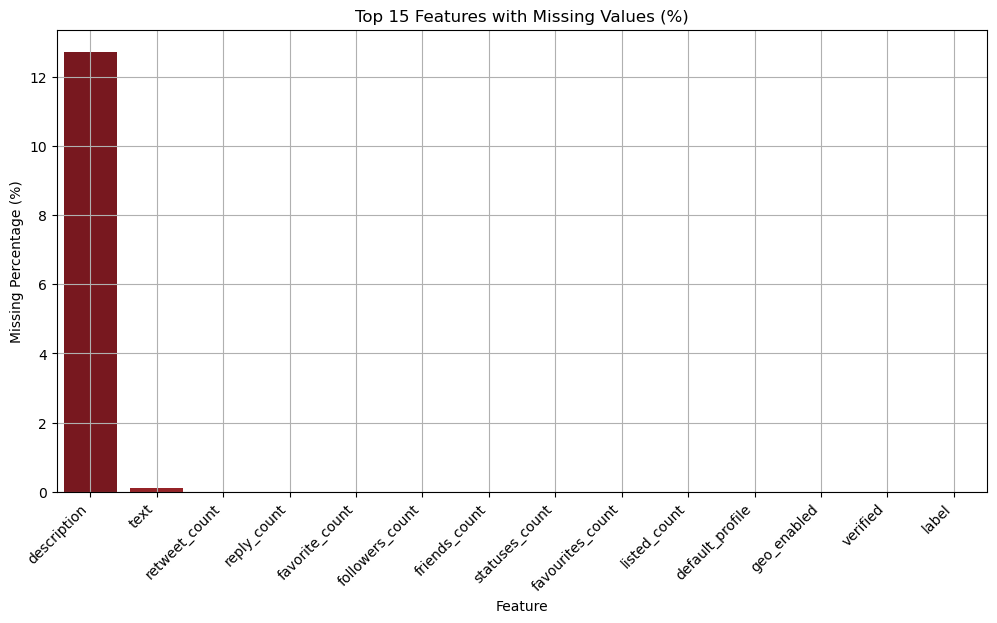

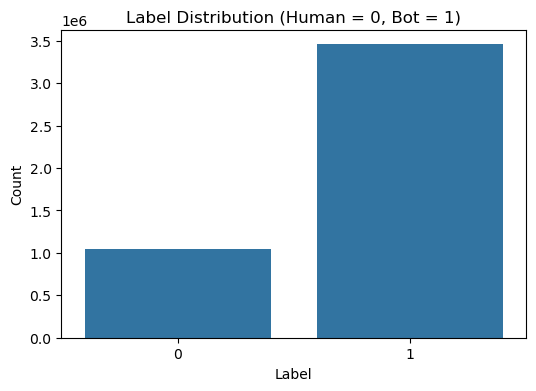

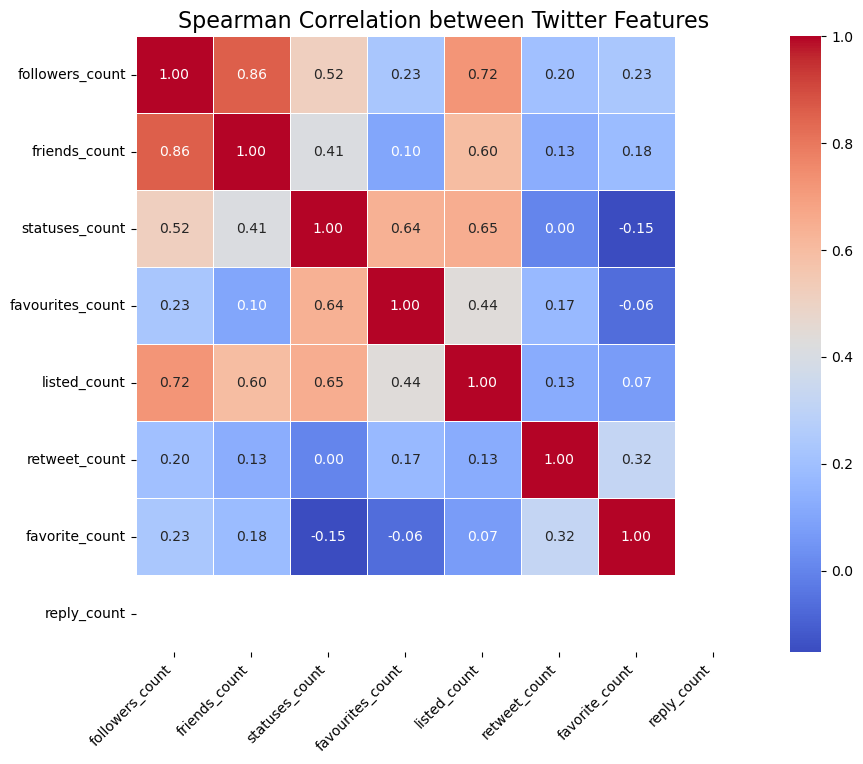

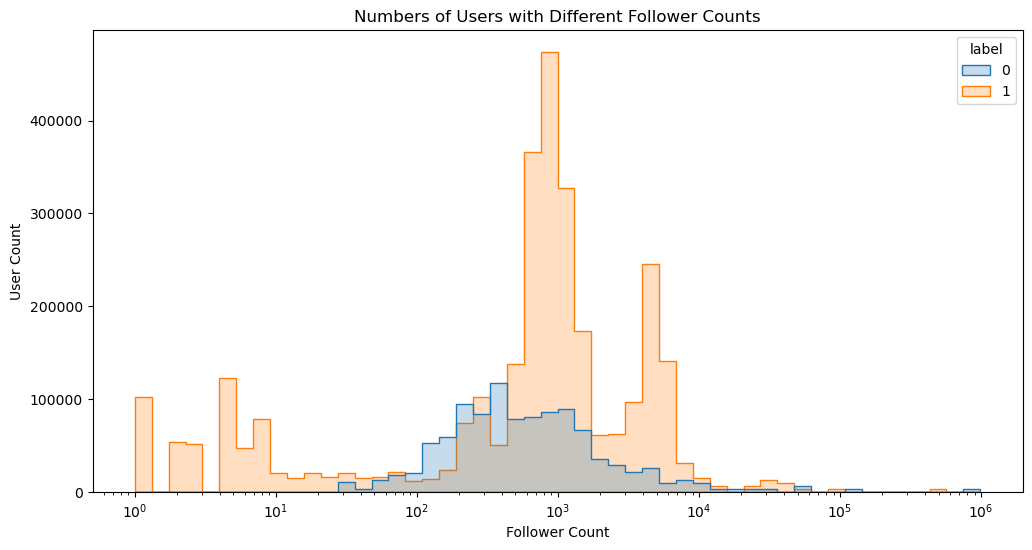

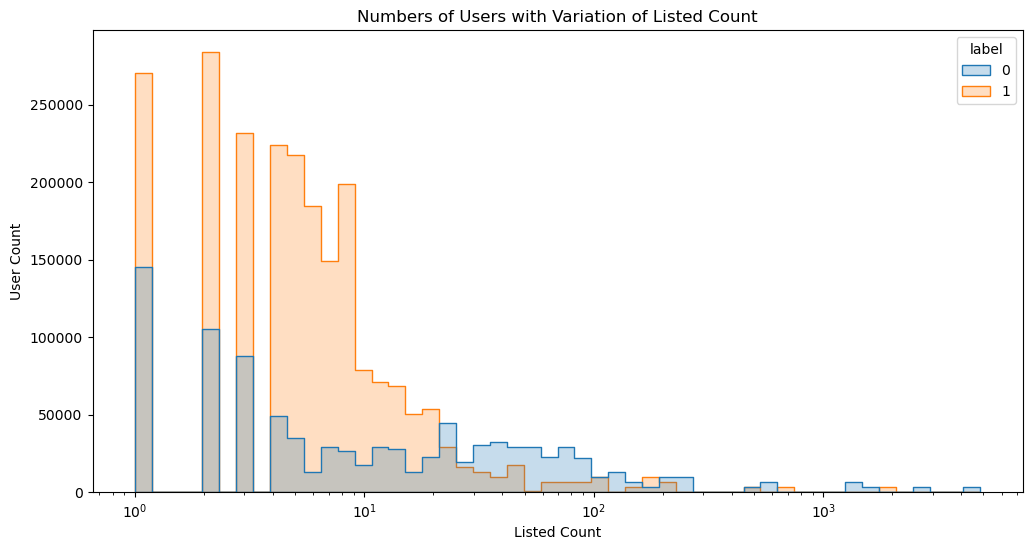

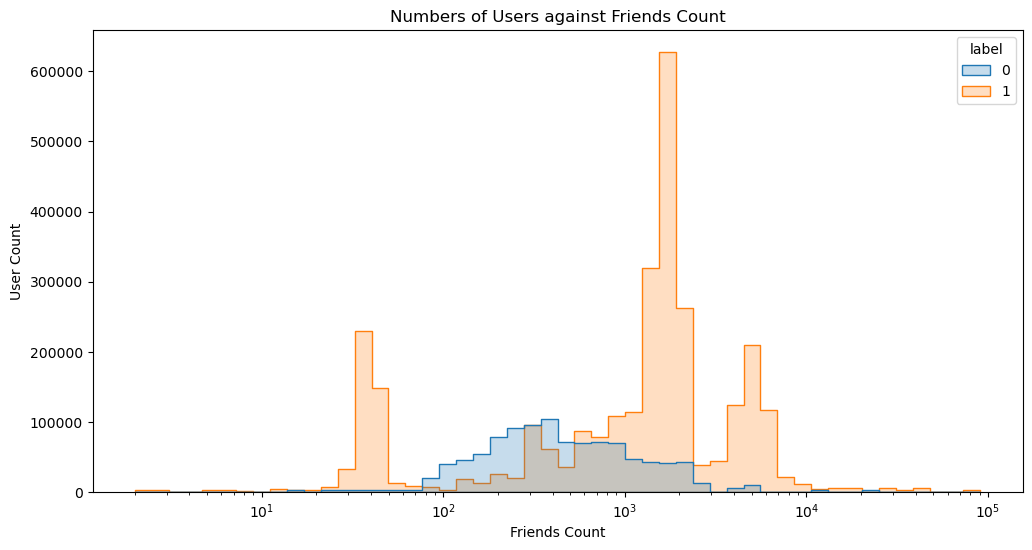

C:\Users\leopa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


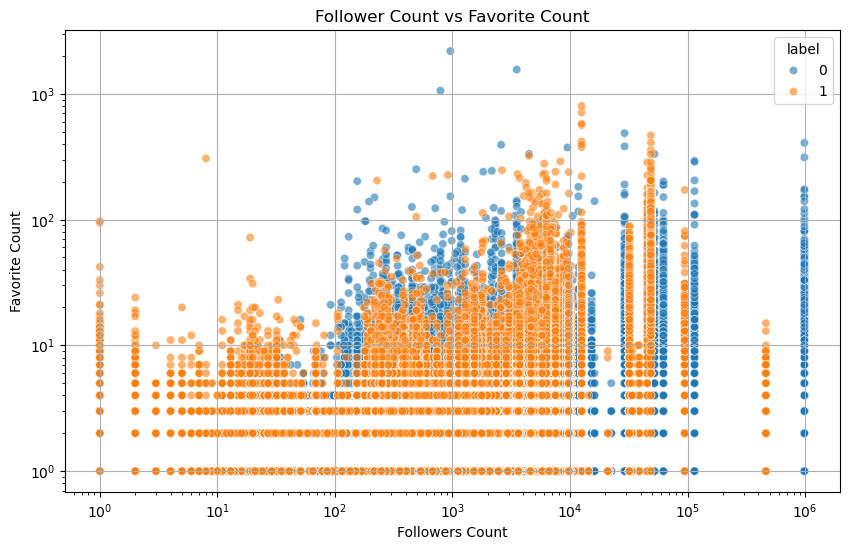

C:\Users\leopa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


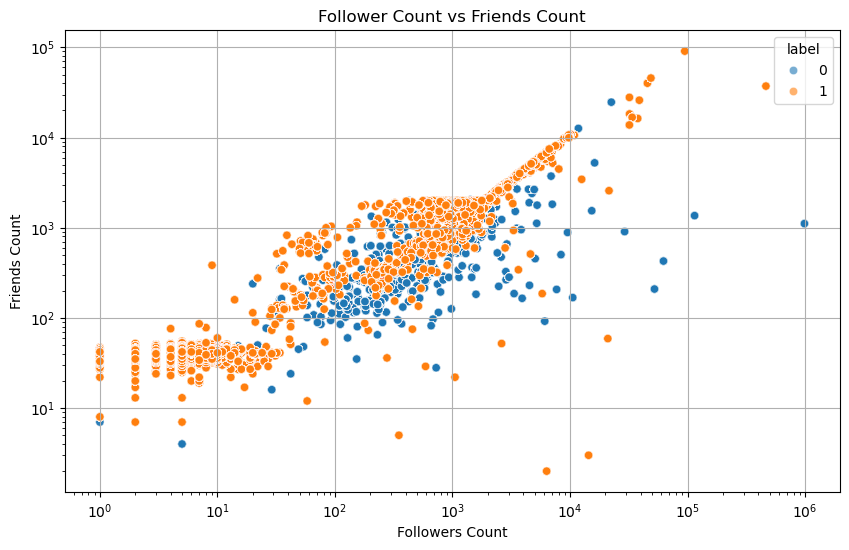

C:\Users\leopa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


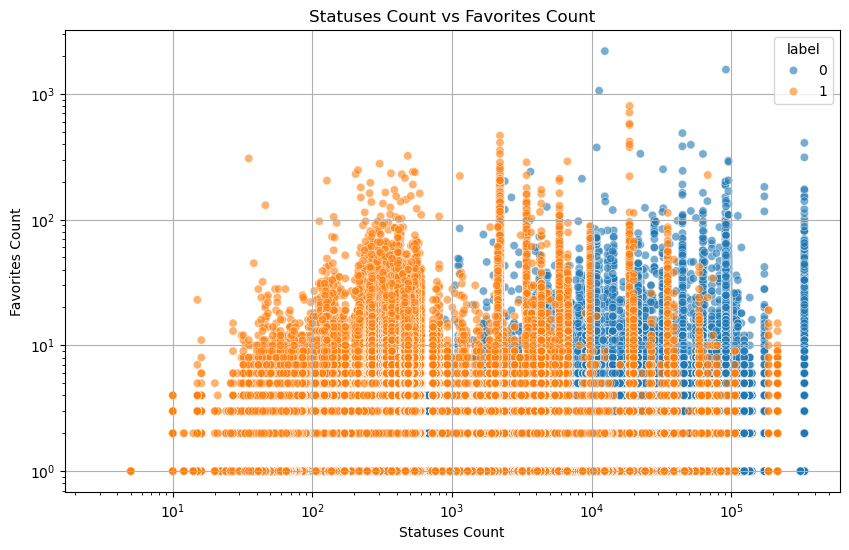

✅ All graphs for merged_df generated successfully!


In [25]:
import pandas as pd
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Paths
base_path = os.path.expanduser("~/Desktop/Detection-of-Social-Bots-using-Machine-Learning-main/")
save_dir = os.path.join(base_path, "processed")
os.makedirs(save_dir, exist_ok=True)

merged_path = os.path.join(save_dir, "merged_full_df.csv")

# ✅ Skip if already saved
if os.path.exists(merged_path):
    merged_df = pd.read_csv(merged_path, low_memory=False)
    print("✅ Loaded existing merged_full_df.csv")
else:
    print("⚙️ Merging tweets and users...")

    # ✅ Load genuine tweets + users (Excel)
    genuine_tweets = pd.read_excel(os.path.join(base_path, "genuine_accounts.csv/genuine_accounts.csv/tweet.xlsx"))
    genuine_users  = pd.read_excel(os.path.join(base_path, "genuine_accounts.csv/genuine_accounts.csv/user.xlsx"))

    # ✅ Load bot tweets + users (CSV)
    def load_spam_data(folder):
        tweets = pd.read_csv(os.path.join(base_path, folder, folder, "tweets.csv"), encoding="latin-1", low_memory=False)
        users  = pd.read_csv(os.path.join(base_path, folder, folder, "users.csv"), encoding="latin-1", low_memory=False)
        return tweets, users

    st1_tweets, st1_users = load_spam_data("social_spambots_1.csv")
    st2_tweets, st2_users = load_spam_data("social_spambots_2.csv")
    st3_tweets, st3_users = load_spam_data("social_spambots_3.csv")

    spam_tweets = pd.concat([st1_tweets, st2_tweets, st3_tweets], ignore_index=True)
    spam_users  = pd.concat([st1_users, st2_users, st3_users], ignore_index=True)

    # ✅ Label users
    genuine_users["label"] = 0
    spam_users["label"] = 1

    # ✅ Merge tweets with users
    all_users  = pd.concat([genuine_users, spam_users], ignore_index=True)
    all_tweets = pd.concat([genuine_tweets, spam_tweets], ignore_index=True)

    merged_df = pd.merge(all_tweets, all_users, left_on="user_id", right_on="id", how="inner")

    print("✅ Merge done. Shape:", merged_df.shape)

    # ✅ Fill useful defaults
    fill_defaults = {
        "text": "",
        "description": "",
        "retweet_count": 0,
        "reply_count": 0,
        "favorite_count": 0,
        "followers_count": 0,
        "friends_count": 0,
        "statuses_count": 0,
        "favourites_count": 0,
        "listed_count": 0,
        "default_profile": False,
        "geo_enabled": False,
        "verified": False
    }

    for col, default in fill_defaults.items():
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].fillna(default)

    # ✅ Filter relevant columns
    selected_cols = [
        "text", "retweet_count", "reply_count", "favorite_count", "followers_count",
        "friends_count", "statuses_count", "favourites_count", "listed_count",
        "default_profile", "geo_enabled", "verified", "description", "label"
    ]
    merged_df = merged_df[selected_cols]

    # ✅ Drop any rows missing text or label
    merged_df = merged_df.dropna(subset=["text", "label"])
    merged_df["text"] = merged_df["text"].astype(str)

    # ✅ Save
    merged_df.to_csv(merged_path, index=False)
    print("✅ Saved merged_full_df.csv")

# ✅ Summary
print("\n🔍 Label Distribution:")
print(merged_df["label"].value_counts())
print("🔹 Final Shape:", merged_df.shape)

# ✅ Missingness Analysis
missing_counts = merged_df.isnull().sum()
missing_percents = (missing_counts / len(merged_df)) * 100
missing_df = pd.DataFrame({"Missing Count": missing_counts, "Missing Percentage (%)": missing_percents}).sort_values(by="Missing Percentage (%)", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=missing_df.index[:15], y=missing_df["Missing Percentage (%)"].values[:15], palette="Reds_r")
plt.xticks(rotation=45, ha="right")
plt.title("Top 15 Features with Missing Values (%)")
plt.ylabel("Missing Percentage (%)")
plt.xlabel("Feature")
plt.grid(True)
plt.show()

# ✅ Label Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=merged_df)
plt.title('Label Distribution (Human = 0, Bot = 1)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# ✅ Spearman Correlation Heatmap
available_features = [
    'followers_count', 'friends_count', 'statuses_count', 'favourites_count',
    'listed_count', 'retweet_count', 'favorite_count', 'reply_count'
]
available_features = [col for col in available_features if col in merged_df.columns]
twitter_data = merged_df[available_features]

spearman_corr = twitter_data.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Spearman Correlation between Twitter Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# ✅ User Quantity based on profile parameters
plt.figure(figsize=(12,6))
sns.histplot(data=merged_df, x="followers_count", bins=50, hue="label", element="step", log_scale=(True, False))
plt.title("Numbers of Users with Different Follower Counts")
plt.xlabel("Follower Count")
plt.ylabel("User Count")
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(data=merged_df, x="listed_count", bins=50, hue="label", element="step", log_scale=(True, False))
plt.title("Numbers of Users with Variation of Listed Count")
plt.xlabel("Listed Count")
plt.ylabel("User Count")
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(data=merged_df, x="friends_count", bins=50, hue="label", element="step", log_scale=(True, False))
plt.title("Numbers of Users against Friends Count")
plt.xlabel("Friends Count")
plt.ylabel("User Count")
plt.show()

# ✅ Followers vs Favorites and Friends Comparison
plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_df, x="followers_count", y="favorite_count", hue="label", alpha=0.6)
plt.title("Follower Count vs Favorite Count")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Followers Count")
plt.ylabel("Favorite Count")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_df, x="followers_count", y="friends_count", hue="label", alpha=0.6)
plt.title("Follower Count vs Friends Count")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Followers Count")
plt.ylabel("Friends Count")
plt.grid(True)
plt.show()

# ✅ Statuses vs Favorites
plt.figure(figsize=(10,6))
sns.scatterplot(data=merged_df, x="statuses_count", y="favorite_count", hue="label", alpha=0.6)
plt.title("Statuses Count vs Favorites Count")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Statuses Count")
plt.ylabel("Favorites Count")
plt.grid(True)
plt.show()

print("✅ All graphs for merged_df generated successfully!")



In [20]:
import pandas as pd

df = pd.read_csv("~/Desktop/Detection-of-Social-Bots-using-Machine-Learning-main/processed/merged_full_df.csv")
print("✅ Shape:", df.shape)
print("\n🔍 Label counts:\n", df["label"].value_counts())


C:\Users\leopa\AppData\Local\Temp\ipykernel_43880\1065669355.py:3: DtypeWarning: Columns (9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("~/Desktop/Detection-of-Social-Bots-using-Machine-Learning-main/processed/merged_full_df.csv")


✅ Shape: (4505708, 14)

🔍 Label counts:
 label
1    3457133
0    1048575
Name: count, dtype: int64


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leopa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\leopa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Loaded merged_full_df.csv. Shape: (4505708, 14)


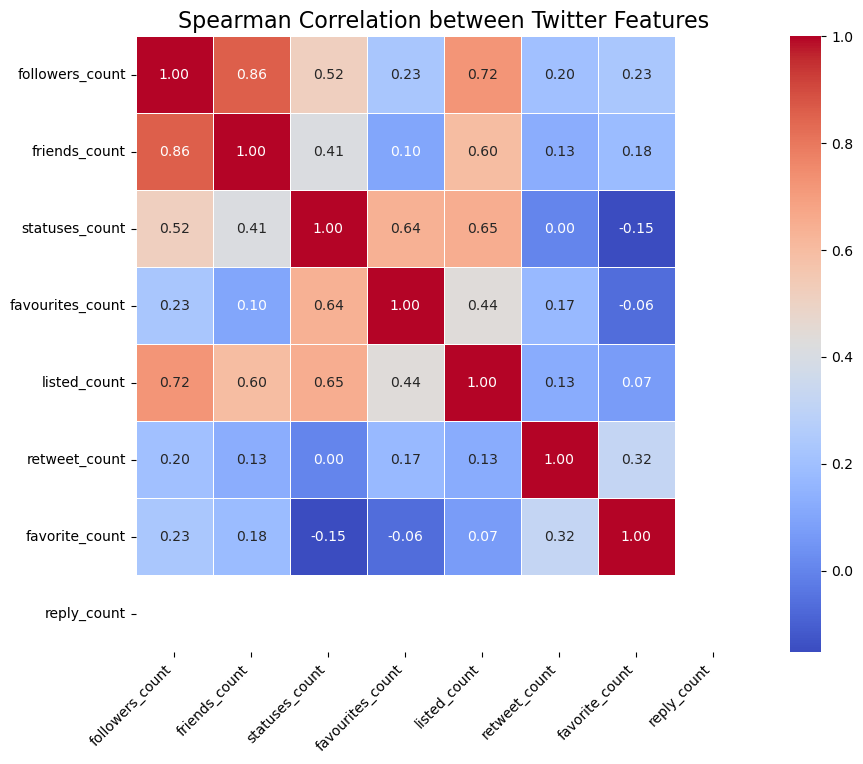

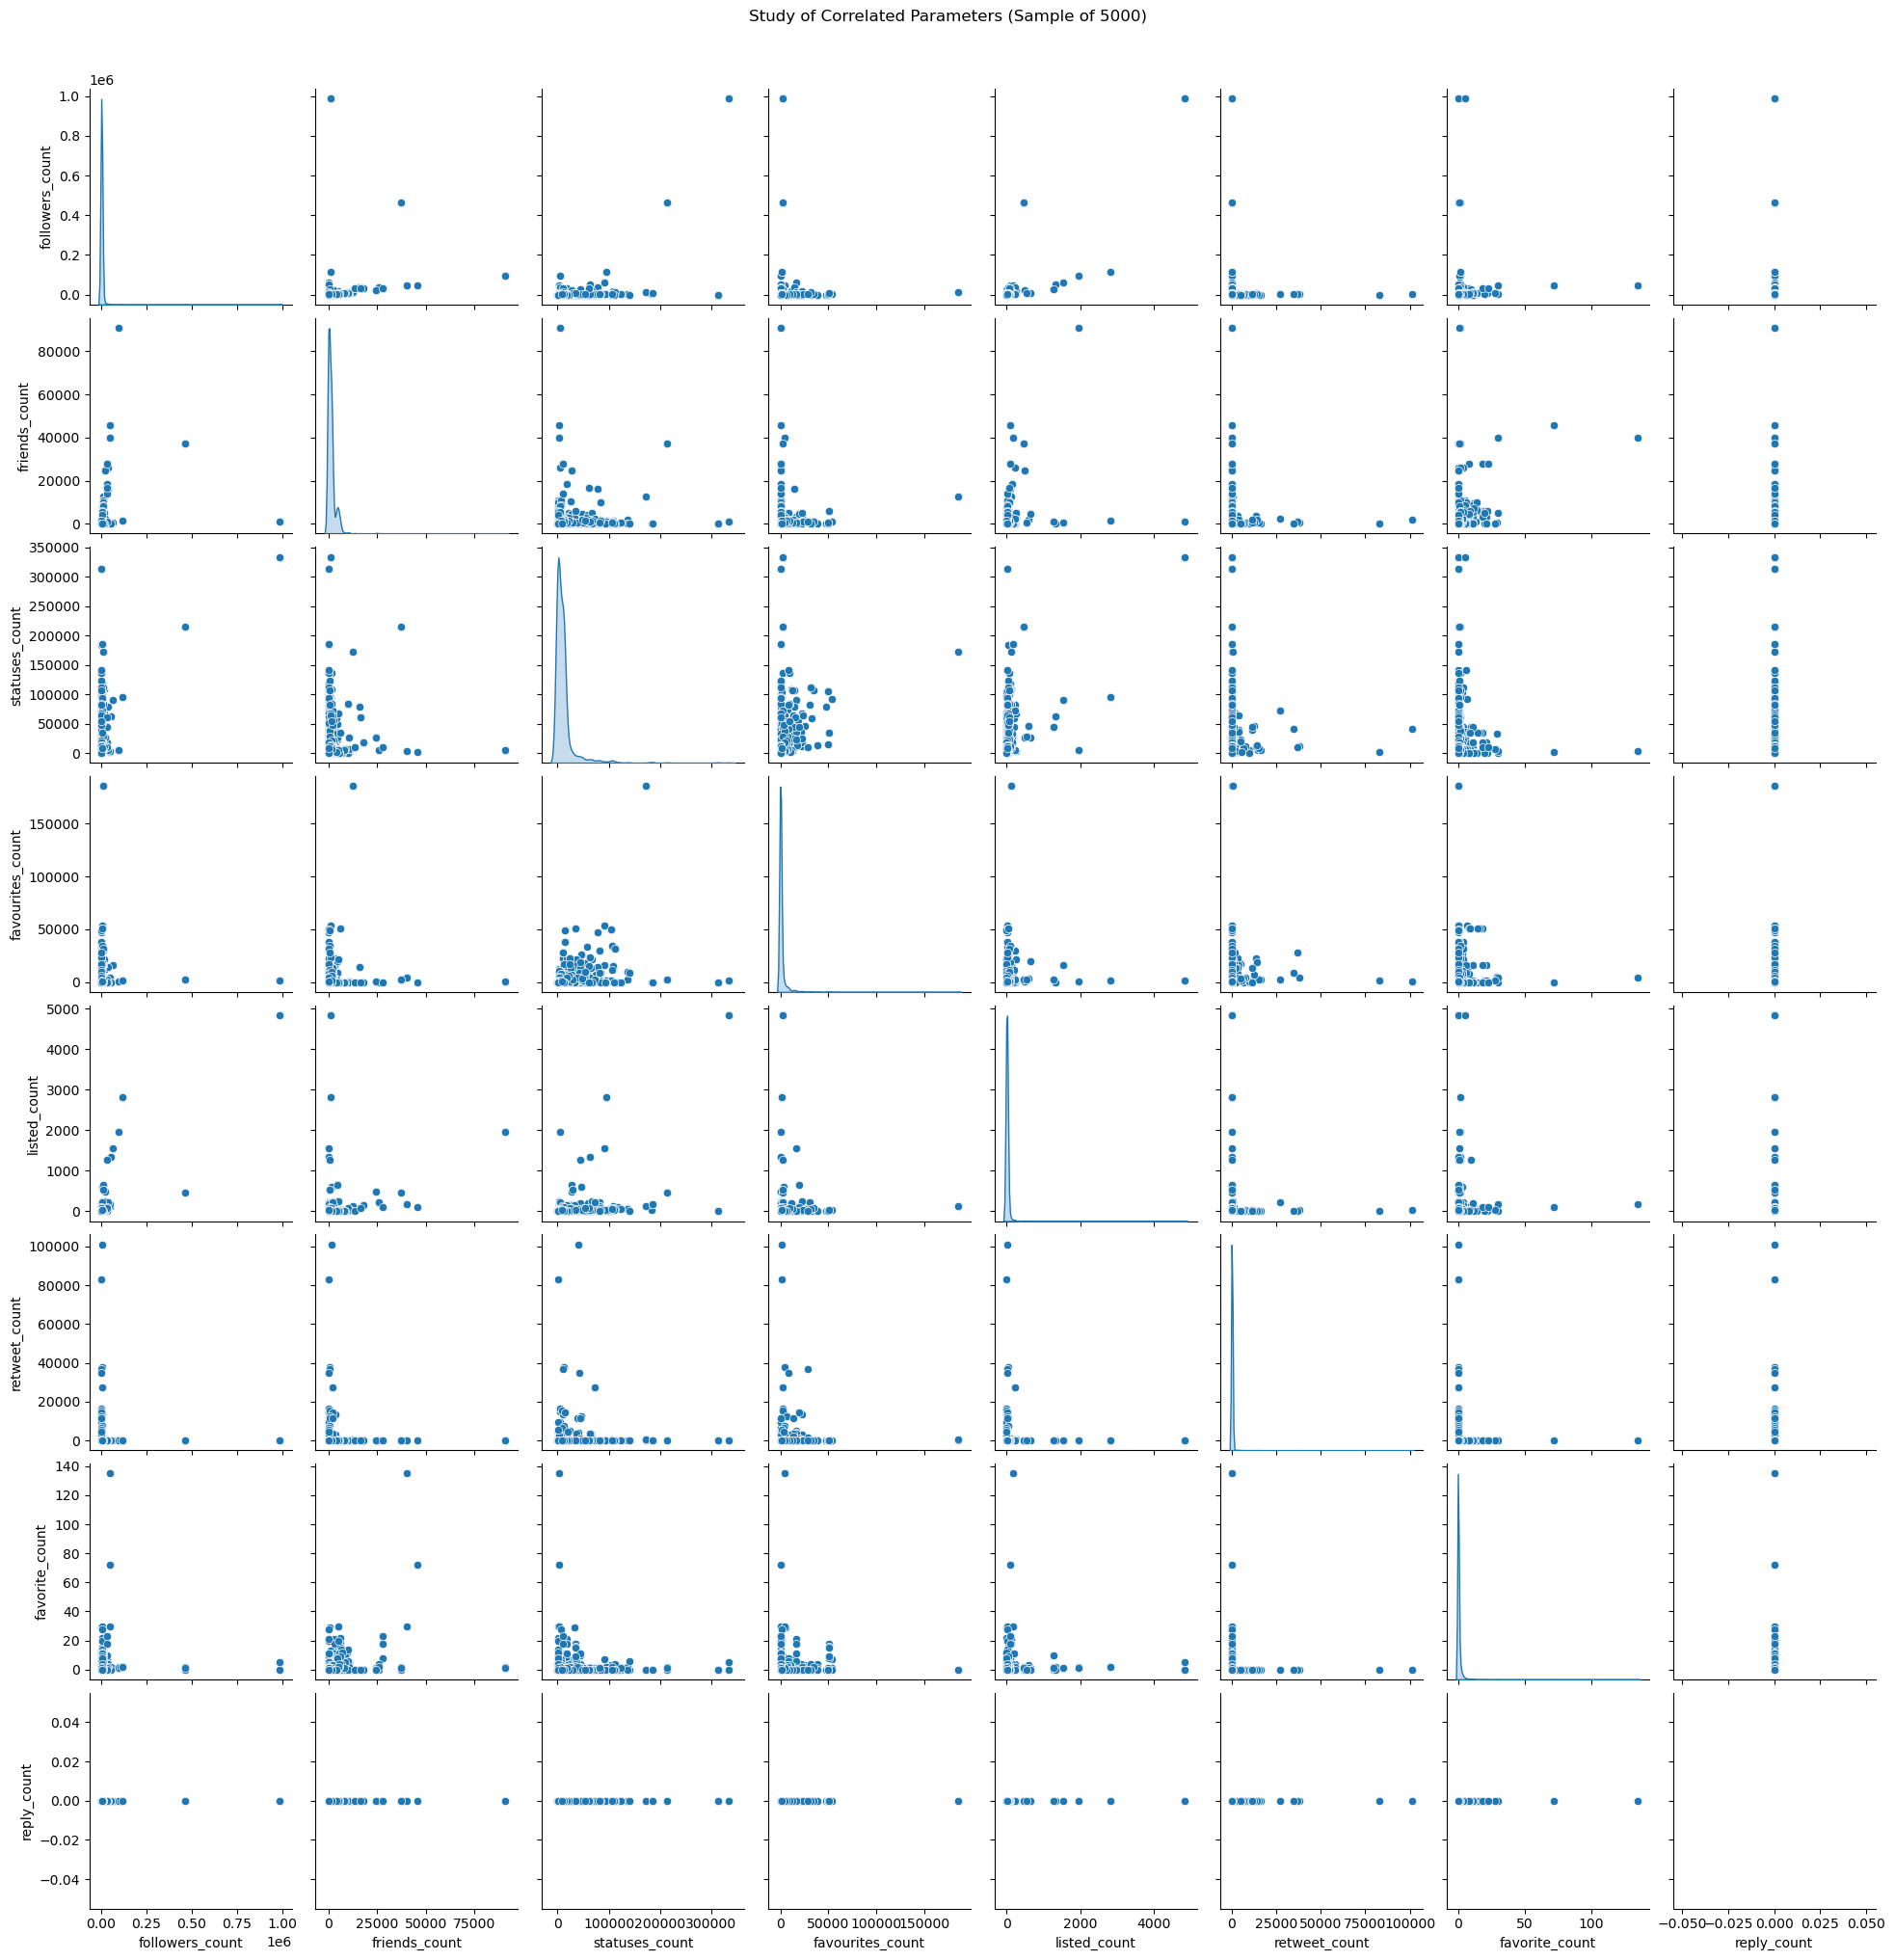

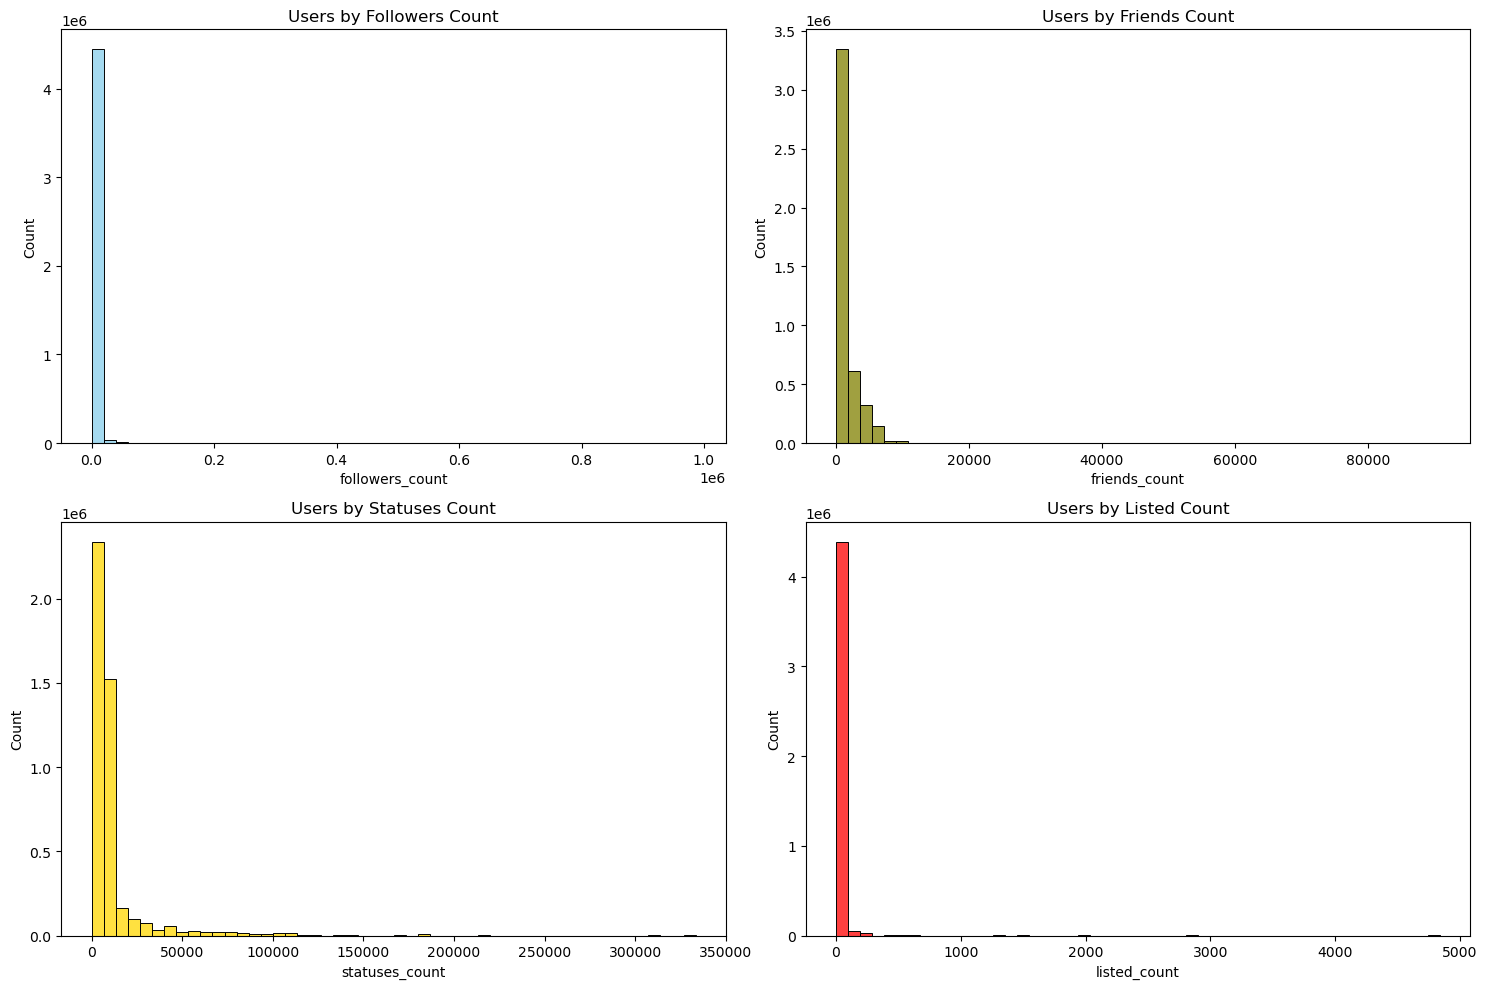

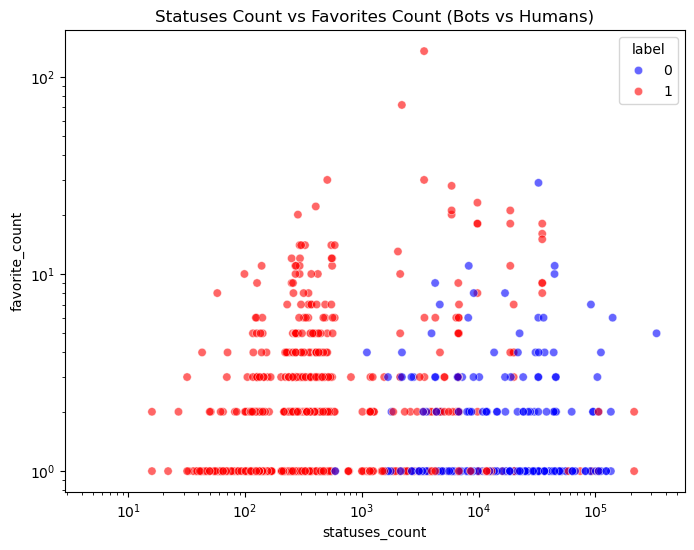

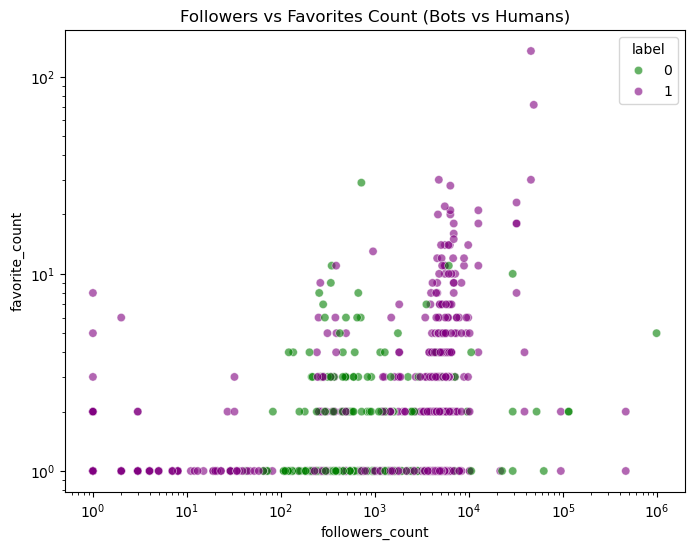

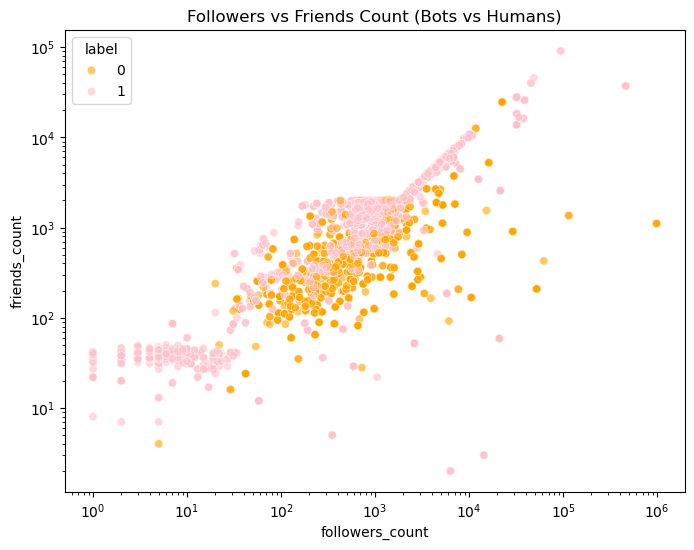

✅ Balancing classes to 1013943 samples each.
✅ Saved cleaned_df.csv with 2027886 balanced entries.

🔍 Final label counts:
 label
0    1013943
1    1013943
Name: count, dtype: int64
🧑‍💻 Sample Human Tweet:
 think going interesting marvel handle year recast avenger little little
🤖 Sample Bot Tweet:
 vedere lorario sul telefono due volta perchã la prima volta lhai dimenticato


In [27]:
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Download required NLTK resources (only once)
nltk.download('stopwords')
nltk.download('wordnet')

# ✅ Paths
base_path = os.path.expanduser("~/Desktop/Detection-of-Social-Bots-using-Machine-Learning-main/")
save_dir = os.path.join(base_path, "processed")
merged_path = os.path.join(save_dir, "merged_full_df.csv")
cleaned_path = os.path.join(save_dir, "cleaned_df.csv")

# ✅ Load dataset
df = pd.read_csv(merged_path, low_memory=False)
print("✅ Loaded merged_full_df.csv. Shape:", df.shape)

# ✅ Select numeric features related to Twitter accounts
twitter_features = [
    'followers_count', 
    'friends_count', 
    'statuses_count', 
    'favourites_count',
    'listed_count', 
    'retweet_count', 
    'favorite_count', 
    'reply_count'
]

available_features = [col for col in twitter_features if col in df.columns]
twitter_data = df[available_features]

# ✅ Calculate Spearman Correlation
spearman_corr = twitter_data.corr(method='spearman')

# ✅ 📊 Spearman Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    spearman_corr, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    square=True, 
    linewidths=0.5
)
plt.title('Spearman Correlation between Twitter Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# ✅ 📊 Study of Correlated Parameters (Pair Plot)
if len(available_features) > 1:
    sns.pairplot(twitter_data.sample(5000, random_state=42), diag_kind="kde")
    plt.suptitle('Study of Correlated Parameters (Sample of 5000)', y=1.02)
    plt.show()

# ✅ 📊 User Quantity based on Profile Parameters
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(df['followers_count'], bins=50, ax=axs[0, 0], color="skyblue")
axs[0, 0].set_title('Users by Followers Count')

sns.histplot(df['friends_count'], bins=50, ax=axs[0, 1], color="olive")
axs[0, 1].set_title('Users by Friends Count')

sns.histplot(df['statuses_count'], bins=50, ax=axs[1, 0], color="gold")
axs[1, 0].set_title('Users by Statuses Count')

sns.histplot(df['listed_count'], bins=50, ax=axs[1, 1], color="red")
axs[1, 1].set_title('Users by Listed Count')

plt.tight_layout()
plt.show()

# ✅ 📊 Statuses vs Favorites (Bots vs Humans)
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='statuses_count', y='favorite_count', 
    hue='label', 
    data=df.sample(5000, random_state=42),
    palette={0:'blue', 1:'red'},
    alpha=0.6
)
plt.title('Statuses Count vs Favorites Count (Bots vs Humans)')
plt.xscale('log')
plt.yscale('log')
plt.show()

# ✅ 📊 Followers vs Favorites (Bots vs Humans)
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='followers_count', y='favorite_count', 
    hue='label', 
    data=df.sample(5000, random_state=42),
    palette={0:'green', 1:'purple'},
    alpha=0.6
)
plt.title('Followers vs Favorites Count (Bots vs Humans)')
plt.xscale('log')
plt.yscale('log')
plt.show()

# ✅ 📊 Followers vs Friends (Bots vs Humans)
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='followers_count', y='friends_count', 
    hue='label', 
    data=df.sample(5000, random_state=42),
    palette={0:'orange', 1:'pink'},
    alpha=0.6
)
plt.title('Followers vs Friends Count (Bots vs Humans)')
plt.xscale('log')
plt.yscale('log')
plt.show()

# 🔵 Now Text Cleaning + Balancing Logic
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words).strip()

df = df[["text", "label"]].dropna()
df["text"] = df["text"].astype(str)
df["clean_tweet"] = df["text"].apply(clean_text)
df = df[df["clean_tweet"].str.strip() != ""]

# ✅ Rebalance classes
bot_df = df[df["label"] == 1]
human_df = df[df["label"] == 0]

min_class_size = min(len(bot_df), len(human_df))
print(f"✅ Balancing classes to {min_class_size} samples each.")

df_balanced = pd.concat([
    human_df.sample(n=min_class_size, random_state=42),
    bot_df.sample(n=min_class_size, random_state=42)
], ignore_index=True)

# ✅ Shuffle and Save
df_balanced = df_balanced[["clean_tweet", "label"]].sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced.to_csv(cleaned_path, index=False)
print(f"✅ Saved cleaned_df.csv with {len(df_balanced)} balanced entries.")

# ✅ Final check
print("\n🔍 Final label counts:\n", df_balanced["label"].value_counts())
print("🧑‍💻 Sample Human Tweet:\n", df_balanced[df_balanced["label"] == 0]["clean_tweet"].iloc[0])
print("🤖 Sample Bot Tweet:\n", df_balanced[df_balanced["label"] == 1]["clean_tweet"].iloc[0])


In [1]:
!pip install tensorflow


  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.0.1-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.71.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached namex-0.0.9-py3-none-any.whl.metadata (322 bytes)
  Using cached optree-0.15

In [24]:
import pandas as pd

df = pd.read_csv("~/Desktop/Detection-of-Social-Bots-using-Machine-Learning-main/processed/cleaned_df.csv")
print("✅ Shape:", df.shape)
print("\n🔍 Label counts:\n", df["label"].value_counts())


✅ Shape: (2027886, 2)

🔍 Label counts:
 label
0    1013943
1    1013943
Name: count, dtype: int64


✅ Loaded saved TF-IDF features.
✅ Loaded saved LSTM sequences.
🔹 TF-IDF shape: (2027886, 1000)
🔹 LSTM sequence shape: (2027886, 50)
🔹 Labels: {0: 1013943, 1: 1013943}


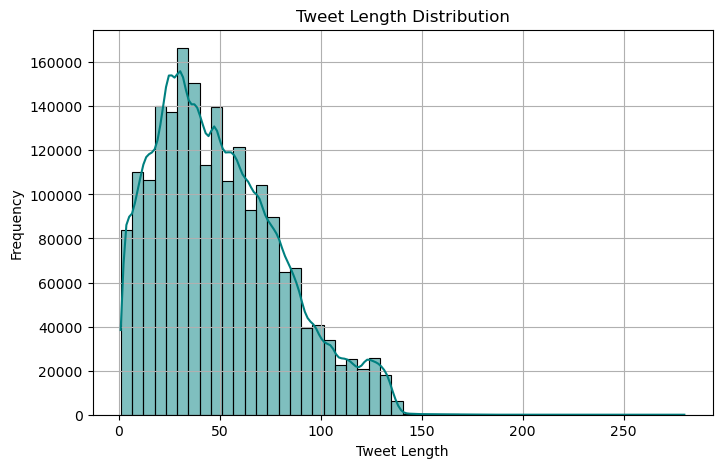

✅ All graphs for this cell generated successfully!


In [29]:
import pandas as pd
import os
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Paths
base_path = os.path.expanduser("~/Desktop/Detection-of-Social-Bots-using-Machine-Learning-main/")
save_dir = os.path.join(base_path, "processed")
cleaned_path = os.path.join(save_dir, "cleaned_df.csv")

# ✅ Output files
tfidf_path = os.path.join(save_dir, "X_tfidf.pkl")
seq_path = os.path.join(save_dir, "X_seq_lstm.npy")
label_path = os.path.join(save_dir, "y_labels.pkl")
tokenizer_path = os.path.join(save_dir, "tokenizer.pkl")
vectorizer_path = os.path.join(save_dir, "tfidf_vectorizer.pkl")

# ✅ Load cleaned data
df = pd.read_csv(cleaned_path)
df['clean_tweet'] = df['clean_tweet'].fillna("").astype(str)  # Safety for text
texts = df["clean_tweet"].tolist()
labels = df["label"].values

# -------------------------------
# ✅ TF-IDF (for ML models)
# -------------------------------
if os.path.exists(tfidf_path) and os.path.exists(label_path) and os.path.exists(vectorizer_path):
    X_tfidf = joblib.load(tfidf_path)
    tfidf_vectorizer = joblib.load(vectorizer_path)
    print("✅ Loaded saved TF-IDF features.")
else:
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
    X_tfidf = tfidf_vectorizer.fit_transform(texts)
    joblib.dump(X_tfidf, tfidf_path)
    joblib.dump(tfidf_vectorizer, vectorizer_path)
    print("✅ Generated and saved TF-IDF features.")

joblib.dump(labels, label_path)

# -------------------------------
# ✅ Tokenizer + Sequences (for LSTM)
# -------------------------------
if os.path.exists(seq_path) and os.path.exists(tokenizer_path):
    X_seq = joblib.load(seq_path)
    tokenizer = joblib.load(tokenizer_path)
    print("✅ Loaded saved LSTM sequences.")
else:
    max_words = 10000
    max_len = 50
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X_seq = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
    joblib.dump(X_seq, seq_path)
    joblib.dump(tokenizer, tokenizer_path)
    print("✅ Generated and saved LSTM sequences.")

# ✅ Final Summary
print("🔹 TF-IDF shape:", X_tfidf.shape)
print("🔹 LSTM sequence shape:", X_seq.shape)
print("🔹 Labels:", pd.Series(labels).value_counts().to_dict())

# -------------------------------
# 🎯 Graphs Section
# -------------------------------

# ✅ Plot: Tweet Length Distribution
df['tweet_length'] = df['clean_tweet'].apply(lambda x: len(x))

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='tweet_length', bins=50, kde=True, color="teal")
plt.title('Tweet Length Distribution')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# ✅ 📊 Numbers of Users with Different Follower Counts
if "followers_count" in df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df['followers_count'], bins=50, color="orange", kde=True)
    plt.title('Distribution of Followers Count')
    plt.xlabel('Followers')
    plt.ylabel('Number of Users')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

# ✅ 📊 Numbers of Users with Variation of Listed Count
if "listed_count" in df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df['listed_count'], bins=50, color="purple", kde=True)
    plt.title('Distribution of Listed Count')
    plt.xlabel('Listed Count')
    plt.ylabel('Number of Users')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

# ✅ 📊 Numbers of Users against Friends Count
if "friends_count" in df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df['friends_count'], bins=50, color="green", kde=True)
    plt.title('Distribution of Friends Count')
    plt.xlabel('Friends')
    plt.ylabel('Number of Users')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

# ✅ 📊 Numbers of Users against Statuses Count
if "statuses_count" in df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df['statuses_count'], bins=50, color="blue", kde=True)
    plt.title('Distribution of Statuses Count')
    plt.xlabel('Statuses')
    plt.ylabel('Number of Users')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

print("✅ All graphs for this cell generated successfully!")


✅ Loaded existing model: LogisticRegression

📊 LogisticRegression Train Accuracy: 0.8679
📊 LogisticRegression Test Accuracy: 0.8665
📋 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87    202789
           1       0.91      0.82      0.86    202789

    accuracy                           0.87    405578
   macro avg       0.87      0.87      0.87    405578
weighted avg       0.87      0.87      0.87    405578

✅ Loaded existing model: NaiveBayes

📊 NaiveBayes Train Accuracy: 0.8235
📊 NaiveBayes Test Accuracy: 0.8232
📋 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.96      0.84    202789
           1       0.94      0.69      0.80    202789

    accuracy                           0.82    405578
   macro avg       0.85      0.82      0.82    405578
weighted avg       0.85      0.82      0.82    405578

✅ Loaded existing model: RandomForest
✅ Using batch pred

C:\Users\leopa\AppData\Local\Temp\ipykernel_27488\2952324901.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette="Blues_d")


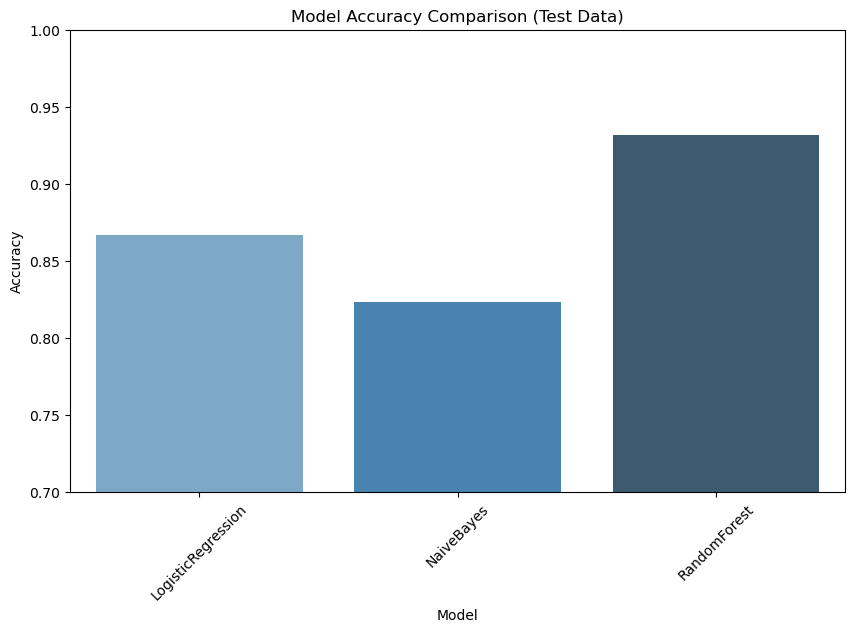

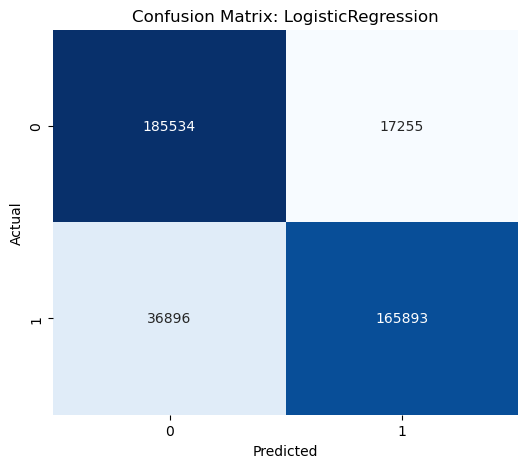

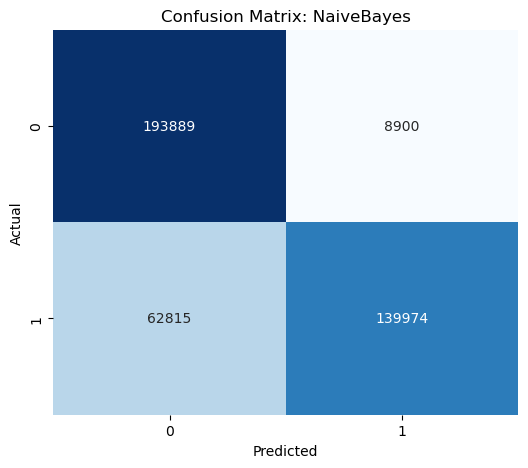

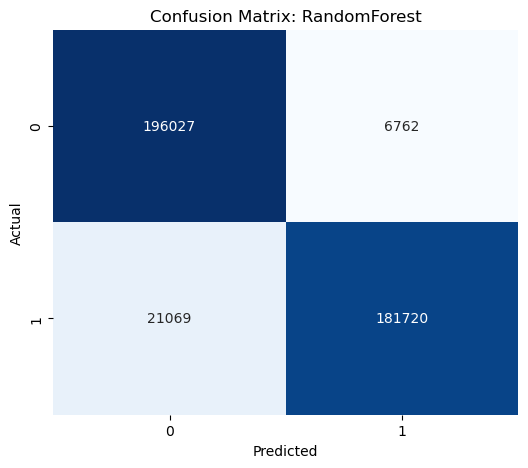

In [3]:
# ✅ Imports
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# ✅ Paths
base_path = os.path.expanduser("~/Desktop/Detection-of-Social-Bots-using-Machine-Learning-main/")
save_dir = os.path.join(base_path, "processed")

# ✅ Load precomputed features
X = joblib.load(os.path.join(save_dir, "X_tfidf.pkl"))
y = joblib.load(os.path.join(save_dir, "y_labels.pkl"))

# ✅ Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Define fast models only (SVM removed)
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "NaiveBayes": MultinomialNB(),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
}

# ✅ Store model performances
model_accuracies = {}
confusion_matrices = {}

# ✅ Safe Batch Prediction Function
def batch_predict(model, X, batch_size=10000):
    n = X.shape[0]
    preds = []
    for i in range(0, n, batch_size):
        preds.append(model.predict(X[i:i+batch_size]))
    return np.concatenate(preds)

# ✅ Train and save each model
for name, model in models.items():
    model_path = os.path.join(save_dir, f"{name}_model.pkl")

    if os.path.exists(model_path):
        print(f"✅ Loaded existing model: {name}")
        trained_model = joblib.load(model_path)
    else:
        print(f"🚀 Training {name}...")
        model.fit(X_train, y_train)
        joblib.dump(model, model_path)
        trained_model = model
        print(f"✅ Saved model to: {model_path}")

    # ✅ Evaluation
    train_preds = trained_model.predict(X_train)
    
    if name == "RandomForest":
        print("✅ Using batch prediction for RandomForest...")
        test_preds = batch_predict(trained_model, X_test)
    else:
        test_preds = trained_model.predict(X_test)

    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)

    model_accuracies[name] = test_acc
    confusion_matrices[name] = confusion_matrix(y_test, test_preds)

    print(f"\n📊 {name} Train Accuracy: {train_acc:.4f}")
    print(f"📊 {name} Test Accuracy: {test_acc:.4f}")
    print("📋 Classification Report:")
    print(classification_report(y_test, test_preds))

# ✅ Plot: Model Accuracy Comparison
plt.figure(figsize=(10,6))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette="Blues_d")
plt.ylim(0.7, 1)
plt.title('Model Accuracy Comparison (Test Data)')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# ✅ Plot: Confusion Matrices
for name, cm in confusion_matrices.items():
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
